### 任务2 - 特征工程
- 特征衍生
- 特征挑选：分别用IV值和随机森林等进行特征选择

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)

# From Task 1 数据清洗
df = pd.read_csv('data.csv', encoding = 'GBK')
df = df.drop(['Unnamed: 0', 'custid', 'trade_no', 'bank_card_no', 'id_name'],axis = 1)
df = df.fillna(0)
df['latest_query_time'] = pd.to_datetime(df['latest_query_time'], format='%Y-%m-%d')
df['loans_latest_time'] = pd.to_datetime(df['loans_latest_time'], format='%Y-%m-%d')
d_city = {0:0, '一线城市':5, '三线城市':4, '二线城市':3, '其他城市':2, '境外':1}
df['reg_preference_for_trad'] = df['reg_preference_for_trad'].map(d_city)

print(df.shape)

(4754, 85)


#### 分箱+IV

In [2]:
# Ref:
# https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb
# https://nbviewer.jupyter.org/github/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 10
force_bin = 3

# Bining for numeric variables
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

# Bining for character variables
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [3]:
final_iv, IV = data_vars(df, df.status)

In [4]:
IV.sort_values('IV').tail(30)

,VAR_NAME,IV
55,number_of_trans_from_2011,0.010676
37,loans_count,0.011276
57,pawns_auctions_trusts_consume_last_6_month,0.011513
58,query_cash_count,0.014679
76,trans_days_interval,0.016214
32,latest_six_month_loan,0.023098
9,consfin_max_limit,0.023166
5,avg_price_top_last_12_valid_month,0.027039
4,avg_price_last_12_month,0.027648
8,consfin_credit_limit,0.031105


#### Random Forest 随机森林

In [5]:
# Ref:
# https://www.datascience.com/resources/notebooks/random-forest-intro

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

df = df.drop(['latest_query_time', 'loans_latest_time', 'source'],axis = 1)
training_set = df.iloc[:, df.columns != 'status']
class_set = df.iloc[:, df.columns == 'status']

class_set = class_set.values.ravel()
fit_rf = RandomForestClassifier(random_state=2018)

In [6]:
# TO-DO: Hyperparameter tuning - GridSearchCV
fit_rf.set_params(criterion = 'gini',
                  max_features = 'log2',
                  max_depth = 3,
                  n_estimators=400,
                  bootstrap = True,
                  warm_start=False,
                  oob_score=False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)

In [7]:
#training_set.info()
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)

In [8]:
# Feature importance analysis
importances_rf = fit_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

print(importances_rf.shape)
print(indices_rf.shape)

data = training_set.iloc[:, indices_rf[:20]]
print(data.columns)

(81,)
(81,)
Index(['trans_fail_top_count_enum_last_1_month', 'history_fail_fee',
       'latest_one_month_fail', 'loans_score', 'loans_overdue_count',
       'apply_score', 'trans_fail_top_count_enum_last_6_month',
       'trans_fail_top_count_enum_last_12_month',
       'max_cumulative_consume_later_1_month', 'latest_one_month_suc',
       'trans_day_last_12_month', 'rank_trad_1_month',
       'trans_top_time_last_1_month', 'consume_top_time_last_1_month',
       'top_trans_count_last_1_month', 'trans_amount_3_month',
       'pawns_auctions_trusts_consume_last_1_month', 'consfin_avg_limit',
       'latest_three_month_loan', 'latest_six_month_loan'],
      dtype='object')


In [9]:
def variable_importance(importance, indices):
    print("Feature ranking:")

    for f in range(len(training_set.columns)):
        i = f
        print("%d. '%s' = %f" %\
             (f + 1, training_set.columns[indices[i]], importance[indices[f]]))
        
variable_importance(importances_rf, indices_rf)

Feature ranking:
1. 'trans_fail_top_count_enum_last_1_month' = 0.136736
2. 'history_fail_fee' = 0.112108
3. 'latest_one_month_fail' = 0.094983
4. 'loans_score' = 0.088020
5. 'loans_overdue_count' = 0.082050
6. 'apply_score' = 0.069800
7. 'trans_fail_top_count_enum_last_6_month' = 0.053599
8. 'trans_fail_top_count_enum_last_12_month' = 0.041363
9. 'max_cumulative_consume_later_1_month' = 0.028066
10. 'latest_one_month_suc' = 0.025413
11. 'trans_day_last_12_month' = 0.020110
12. 'rank_trad_1_month' = 0.019081
13. 'trans_top_time_last_1_month' = 0.015889
14. 'consume_top_time_last_1_month' = 0.014715
15. 'top_trans_count_last_1_month' = 0.014606
16. 'trans_amount_3_month' = 0.010167
17. 'pawns_auctions_trusts_consume_last_1_month' = 0.009897
18. 'consfin_avg_limit' = 0.009358
19. 'latest_three_month_loan' = 0.008533
20. 'latest_six_month_loan' = 0.008432
21. 'avg_price_last_12_month' = 0.007969
22. 'historical_trans_amount' = 0.006453
23. 'consume_mini_time_last_1_month' = 0.006425
24. 'l

In [10]:
import matplotlib.pyplot as plt

def variable_importance_plot(importance, indices):
    
    index = np.arange(len(training_set.columns))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(80, -1, -1):
        feature_space.append(training_set.columns[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Random Forest Model')
    plt.barh(index, importance_desc, align="center", color = '#875FDB')
    plt.yticks(index, feature_space)

    plt.ylim(50.5, 80.5)
    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

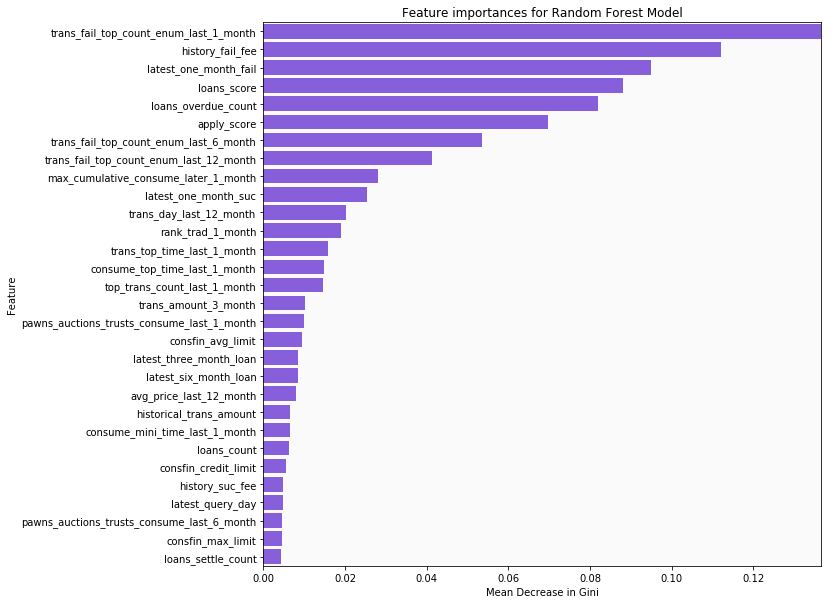

In [11]:
variable_importance_plot(importances_rf, indices_rf)

## Task 3 建模

In [12]:
data.shape

(4754, 20)

In [13]:
import imblearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=420)
X, class_set = sm.fit_sample(data, class_set)

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, class_set, test_size=0.3, random_state=2018)

### Logistic Regression

In [15]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression as LR

lr = LR().fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
acc = metrics.accuracy_score(y_test,y_test_pred)
precision = metrics.precision_score(y_test,y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
f1 = metrics.f1_score(y_test,y_test_pred)
auc= metrics.roc_auc_score(y_test,y_test_pred)
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}, AUC: {:.4f}'.format(acc,precision,recall,f1,auc))

Accuracy: 0.7468, Precision: 0.7786, Recall: 0.6855, F1-score: 0.7291, AUC: 0.7465


### SVM

In [16]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf',gamma='auto',cache_size=5000).fit(X_train, y_train)
#svc.score(X_test, y_test)

y_test_pred = svc.predict(X_test)
acc = metrics.accuracy_score(y_test,y_test_pred)
precision = metrics.precision_score(y_test,y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
f1 = metrics.f1_score(y_test,y_test_pred)
auc= metrics.roc_auc_score(y_test,y_test_pred)
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}, AUC: {:.4f}'.format(acc,precision,recall,f1,auc))

Accuracy: 0.7637, Precision: 0.7749, Recall: 0.7392, F1-score: 0.7566, AUC: 0.7635


### Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier().fit(X_train, y_train)

y_test_pred = dtc.predict(X_test)
acc = metrics.accuracy_score(y_test,y_test_pred)
precision = metrics.precision_score(y_test,y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
f1 = metrics.f1_score(y_test,y_test_pred)
auc= metrics.roc_auc_score(y_test,y_test_pred)
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}, AUC: {:.4f}'.format(acc,precision,recall,f1,auc))

Accuracy: 0.7740, Precision: 0.7644, Recall: 0.7881, F1-score: 0.7761, AUC: 0.7741


### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

y_test_pred = rfc.predict(X_test)
acc = metrics.accuracy_score(y_test,y_test_pred)
precision = metrics.precision_score(y_test,y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
f1 = metrics.f1_score(y_test,y_test_pred)
auc= metrics.roc_auc_score(y_test,y_test_pred)
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}, AUC: {:.4f}'.format(acc,precision,recall,f1,auc))

Accuracy: 0.8320, Precision: 0.8613, Recall: 0.7891, F1-score: 0.8236, AUC: 0.8317


### XGBoost

In [19]:
from xgboost import XGBClassifier as XGBC
xgb = XGBC().fit(X_train, y_train)

y_test_pred = xgb.predict(X_test)
acc = metrics.accuracy_score(y_test,y_test_pred)
precision = metrics.precision_score(y_test,y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
f1 = metrics.f1_score(y_test,y_test_pred)
auc= metrics.roc_auc_score(y_test,y_test_pred)
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}, AUC: {:.4f}'.format(acc,precision,recall,f1,auc))

Accuracy: 0.8484, Precision: 0.8712, Recall: 0.8154, F1-score: 0.8424, AUC: 0.8482
